<a href="https://colab.research.google.com/github/lauraciurca/Algorithms_Massive_Datasets_Project/blob/main/Market_Basket_Analysis_AMD_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ALGORITHM FOR MASSIVE DATASETS: MARKET BASKET ANALYSIS** 

---


#####Laura Ciurca
#####Camilla Gotta
#####2020/2021 

**SPARK SETUP**

---



In [ ]:
#install Java8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null  
#download spark3.0.2
#!apt-get update
!wget -c http://apache.osuosl.org/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
#unzip it
!tar xf spark-3.0.2-bin-hadoop2.7.tgz 
#install findspark
!pip install -q findspark  

--2021-05-07 14:46:10--  http://apache.osuosl.org/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
Resolving apache.osuosl.org (apache.osuosl.org)... 64.50.236.52, 64.50.233.100, 140.211.166.134, ...
Connecting to apache.osuosl.org (apache.osuosl.org)|64.50.236.52|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init("spark-3.0.2-bin-hadoop2.7")  #SPARK_HOME
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
import pyspark
sc = spark.sparkContext 

**KAGGLE SETUP**

---



In [ ]:
!pip install kaggle

Import the dataset through the Kaggle API

In [ ]:
#upload kaggle.json, the file containing the API, to Colab runtime
from google.colab import files
files.upload() 

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"camilla97","key":"c318458ba561de6436dd16b7fc0afeb4"}'}

In [ ]:
#move kaggle.json into the folder where the API expects to find it
!mkdir -p ~/.kaggle 
!mv kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ashirwadsangwan/imdb-dataset

100% 1.44G/1.44G [00:18<00:00, 41.2MB/s]
100% 1.44G/1.44G [00:18<00:00, 82.7MB/s]


Unzip the dataset

In [ ]:
!unzip imdb-dataset.zip  

Archive:  imdb-dataset.zip
  inflating: name.basics.tsv.gz      
  inflating: name.basics.tsv/name.basics.tsv  
  inflating: title.akas.tsv.gz       
  inflating: title.akas.tsv/title.akas.tsv  
  inflating: title.basics.tsv.gz     
  inflating: title.basics.tsv/title.basics.tsv  
  inflating: title.principals.tsv.gz  
  inflating: title.principals.tsv/title.principals.tsv  
  inflating: title.ratings.tsv.gz    
  inflating: title.ratings.tsv/title.ratings.tsv  


Read the dataset on spark

In [ ]:
df = spark.read.csv("/content/title.basics.tsv/title.basics.tsv", sep=r'\t', header=True)
df1 = spark.read.csv("/content/title.principals.tsv/title.principals.tsv", sep=r'\t', header=True)
df2 = spark.read.csv("/content/name.basics.tsv/name.basics.tsv", sep=r'\t', header=True)

**DATA PREPROCESSING**

---



Retrieve only actors and actress as primary profession

In [ ]:
#filtering actor dataset according just for Primary names that have actor or actress roles
df2 = df2.filter((df2.primaryProfession == 'actor')|(df2.primaryProfession == 'actress'))

Select film under category "movie"

In [ ]:
#dataset taking just movies
df = df.filter(df.titleType == 'movie')

In [ ]:
df.createOrReplaceTempView("df")
df1.createOrReplaceTempView("df1")
df2.createOrReplaceTempView("df2")

In [ ]:
df = df.select(['tconst', 'primaryTitle'])
df1 = df1.select(['tconst', 'nconst'])
df2 = df2.select(['primaryName', 'nconst'])

 Dataset needed for analysis derived from an inner join on three main datasets

In [ ]:
#inner join of the datasets
dataset = spark.sql("""SELECT DISTINCT df2.primaryName, df.primaryTitle, df1.tconst, df1.nconst
                       FROM df
                       INNER JOIN df1 ON df.tconst = df1.tconst
                       INNER JOIN df2 ON df1.nconst = df2.nconst
                       LIMIT 70000""")    

In [ ]:
#libraries needed 
from pyspark.sql.functions import collect_set
from pyspark.sql.functions import size, col
from pyspark.sql import functions as F 
from collections import defaultdict
import itertools
import pandas as pd
import time
import matplotlib.pyplot as plt

In [ ]:
#create baskets
basketdata = dataset.groupBy('tconst').agg(collect_set('nconst').alias('nconst'))
basketdata.createOrReplaceTempView('basketdata')
#basketdata.toPandas().head(5)
#basketdata.count()

In [ ]:
#check number of actors for each movie
basketdata=basketdata.select('*',size('nconst').alias('actors'))

Creation of the RDD of the transactions

In [ ]:
#create rdd
transactions=basketdata.select('nconst').rdd.flatMap(lambda x: x)
lines = transactions.map(lambda line: ','.join(str(d) for d in line))
lines.saveAsTextFile('baskets.txt')
bask = sc.textFile('baskets.txt').map(lambda x: [str(y) for y in x.strip().split(',')])

**APRIORI ALGORITHM**

---



In [ ]:
#define support    
count= basketdata.count()        
supports= 0.0003*count     
numPartitions = bask.getNumPartitions()

In [ ]:
#determine candidates
def get_candidates(frequent_items,k):  
    elements=set() 
    if(k>1):
        for itemsets in frequent_items: 
            for item in itemsets: 
                elements.add(item) 
  
    candidate_sets=[set(itemsets) for itemsets in list(itertools.combinations(elements, k))] 
    
    return candidate_sets

In [ ]:
def candidates_basket(iterator,candidates):
  return iterator.flatMap(lambda x: [(tuple(c), 1) for c in candidates if c.issubset(set(x))]).reduceByKey(lambda a,b: a+b).filter(lambda c: c[1] >= supports).collect()

In [ ]:
#determine frequent itemsets
def get_frequent_itemset(iterator):
    baskets = iterator.collect()
    support_part = supports         
    k = 2
    d = {}
    frequent_items = []
    frequent_itemset = []

    for b in baskets:
        for i in b:
            if i not in d:
                d[i] = 1
            else:
                d[i] = d[i] + 1
    
    for i in d:
        if d[i] >= support_part:
            frequent_items.append(i)

    frequent_itemset = [(i,1) for i in frequent_items]

    return(frequent_itemset) 

In [ ]:
#define apriori
def apriori(iterator): 
  
  iterator.cache()
  freq_itemsets = get_frequent_itemset(iterator)
  freq_items = [{i[0]} for i in freq_itemsets]
  k=2
  candidates = get_candidates(freq_items,k)

  while len(candidates) != 0:
    freq_itemsets_2 = candidates_basket(iterator,candidates)
    freq_itemsets += freq_itemsets_2
    freq_items2 = list(map(lambda x: {x[0]}, freq_itemsets_2))

    # new candidates
    candidates = get_candidates(freq_items2, k)
    
    k += 1

  iterator.unpersist()

  return freq_itemsets

In [ ]:
#run apriori
start_time = time.time()
apriori(bask)
print(time.time() - start_time)

1719.518134355545


**FP-GROWTH ALGORITHM**

---



In [ ]:
#implement FpGrowth
from pyspark.ml.fpm import FPGrowth
start_time = time.time()
fpGrowth = FPGrowth(itemsCol="nconst", minSupport=0.00003)
start_time = time.time()
model = fpGrowth.fit(basketdata)
print(time.time() - start_time)

104.07793688774109


In [ ]:
#Display frequentItems
model.freqItemsets.show()

+------------+----+
|       items|freq|
+------------+----+
| [nm1584345]|   2|
| [nm0174856]|   2|
| [nm1052564]|   3|
| [nm0679216]|   2|
| [nm0841021]|   3|
| [nm2166823]|   4|
| [nm2831110]|   2|
|[nm10495249]|   2|
| [nm5963347]|   3|
| [nm6749562]|   2|
| [nm1644203]|   4|
| [nm3234559]|   2|
| [nm4833453]|   2|
| [nm0294165]|   4|
| [nm5792427]|   3|
| [nm2155221]|   2|
| [nm5194283]|   2|
| [nm0814679]|   5|
| [nm8783219]|   2|
| [nm2055054]|   2|
+------------+----+
only showing top 20 rows



In [ ]:
f= model.freqItemsets
f.createOrReplaceTempView("f")

In [ ]:
query = """select items, freq
           from f
           where size(items) > 2
           order by freq desc
           """
spark.sql(query).show()

+--------------------+----+
|               items|freq|
+--------------------+----+
|[nm5598823, nm559...|   7|
|[nm0231108, nm030...|   3|
|[nm0950884, nm753...|   3|
|[nm2198250, nm910...|   2|
|[nm0231108, nm087...|   2|
|[nm0019966, nm023...|   2|
|[nm7205580, nm462...|   2|
|[nm0207578, nm030...|   2|
|[nm0122310, nm014...|   2|
|[nm3135393, nm300...|   2|
|[nm0759664, nm023...|   2|
|[nm2884773, nm286...|   2|
|[nm0140578, nm008...|   2|
|[nm0422380, nm273...|   2|
+--------------------+----+



**DATA VISUALIZATION**

---



Plot the time needed for Apriori algorithm with different sample size of dataset

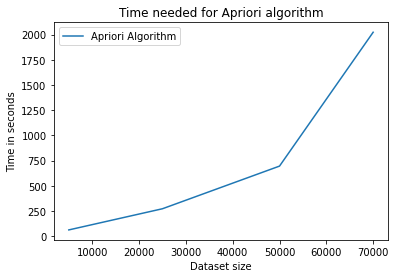

In [ ]:
#get graph for time (seconds) running apriori
w = {'size_dataset': [5000, 25000, 50000, 70000],
     'time_seconds': [63.071523904800415,272.9228575229645,695.7591323852539, 1719.518134355545]}
results = pd.DataFrame(w)
%matplotlib inline
x = results['size_dataset']
y = results['time_seconds']
plt.plot(x, y, label="Apriori Algorithm")

plt.xlabel("Dataset size")
plt.ylabel("Time in seconds")
plt.title('Time needed for Apriori algorithm')

leg = plt.legend()

plt.savefig('image.pdf')

plt.show()


Plot the difference of the runtime for both algorithms with different support values


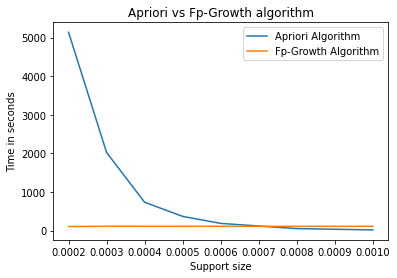

In [ ]:
#get graph for time (seconds) running both algorithm for different support values

%matplotlib inline
x =[0.0002, 0.0003, 0.0004,0.0005, 0.0006, 0.0008, 0.001]
y = [5139.251349925995,2022.997619152069,733.544305562973,367.53301644325256,185.84784150123596,51.371659994125366,17.269320249557495]
plt.plot(x, y, label="Apriori Algorithm")

x1=[0.0002, 0.0003, 0.0004,0.0005, 0.0006, 0.0008, 0.001]
y1=[104.76757955551147,112.26622992477417,111.86981964111328,111.74520134925842,111.484503077698,110.27831411361694,111.74520134925842]
plt.plot(x1, y1, label="Fp-Growth Algorithm")

plt.xlabel("Support size")
plt.ylabel("Time in seconds")
plt.title('Apriori vs Fp-Growth algorithm')

leg = plt.legend()

plt.savefig('image.pdf')

plt.show()